In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam

import sys
sys.path.append('../module/')

import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v1")
env.dt = 0.005
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
# site-packages/gym/envs/classic_control/pendulum.py

# 取りうる”打ち手”のアクション数と値の定義
nb_actions = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [11]:
#event-base learning
l = 0.
step = 10000
time_mode = True
a =  agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=2000, loss_graph=0, time_mode=time_mode)

Training for 10000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 66s 7ms/step - reward: -9.1589
done, took 66.127 seconds


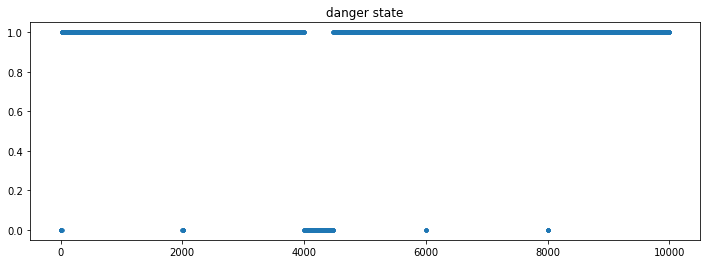

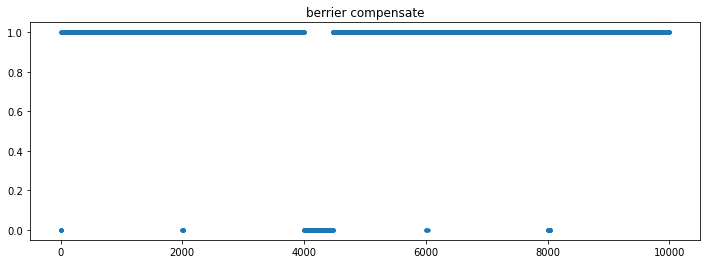

In [12]:
plt.figure(figsize=(12,4))
plt.title('danger state')
plt.scatter(range(step), a.cbf_log[:,0], marker='.')
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.scatter(range(step), a.cbf_log[:,1], marker='.')
plt.show()

In [7]:
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.test(env, lam=l, visualize=0, nb_max_episode_steps=2000, action_view=0, time_mode=time_mode)

Testing for 1 episodes ...
0 : sin(theta) = -0.1278727466918651
1 : sin(theta) = -0.135946713383118
2 : sin(theta) = -0.13420598123177707
3 : sin(theta) = -0.12257897739438722
4 : sin(theta) = -0.10059023246128972
5 : sin(theta) = -0.06735435009709653
6 : sin(theta) = -0.021574231469102746
7 : sin(theta) = 0.03843506716202141
8 : sin(theta) = 0.11465360033231854
9 : sin(theta) = 0.20911274812938704
10 : sin(theta) = 0.2948232631646197
11 : sin(theta) = 0.3745667125542169
12 : sin(theta) = 0.4507760530084447
13 : sin(theta) = 0.525449861863568
14 : sin(theta) = 0.6000449952919749
15 : sin(theta) = 0.6753009219257465
16 : sin(theta) = 0.7509580426358873
17 : sin(theta) = 0.8253442864886609
18 : sin(theta) = 0.8948352879962744
19 : sin(theta) = 0.9532663603380058
20 : sin(theta) = 0.9915134313502387
21 : sin(theta) = 0.9976641833265105
22 : sin(theta) = 0.9583835825429642
23 : sin(theta) = 0.8619977272326622
24 : sin(theta) = 0.703126461692226
25 : sin(theta) = 0.48730858324076504
26 : si

223 : sin(theta) = 0.03337307828463138
224 : sin(theta) = 0.020414191520121108
225 : sin(theta) = 0.021684711035597822
226 : sin(theta) = 0.007143974583159504
227 : sin(theta) = 0.007333695066413487
228 : sin(theta) = -0.007751449678012024
229 : sin(theta) = -0.007546064434098252
230 : sin(theta) = -0.022055978743675608
231 : sin(theta) = -0.020740812172200706
232 : sin(theta) = -0.03364270163828
233 : sin(theta) = -0.03028956806354584
234 : sin(theta) = -0.040792171585211666
235 : sin(theta) = -0.03477606485978684
236 : sin(theta) = -0.04244580518464805
237 : sin(theta) = -0.03353603659233904
238 : sin(theta) = -0.0383590762612115
239 : sin(theta) = -0.026752995488082115
240 : sin(theta) = -0.029136524650246663
241 : sin(theta) = -0.015431877434235838
242 : sin(theta) = -0.0161449343853515
243 : sin(theta) = -0.001253346342916174
244 : sin(theta) = -0.0013140566216264266
245 : sin(theta) = 0.013674083627600616
246 : sin(theta) = 0.013149919442296265
247 : sin(theta) = 0.02712963605043

507 : sin(theta) = 0.03169697129633193
508 : sin(theta) = 0.0287989552730459
509 : sin(theta) = 0.039813107749465296
510 : sin(theta) = 0.03434458159287725
511 : sin(theta) = 0.04257824358846668
512 : sin(theta) = 0.03422753055889578
513 : sin(theta) = 0.039583438564884506
514 : sin(theta) = 0.028465123936739018
515 : sin(theta) = 0.03127161480736678
516 : sin(theta) = 0.017910815055173168
517 : sin(theta) = 0.01887405542960966
518 : sin(theta) = 0.004130790743393102
519 : sin(theta) = 0.004231511507812268
520 : sin(theta) = -0.010826224404452914
521 : sin(theta) = -0.01047822077335059
522 : sin(theta) = -0.024734932961702552
523 : sin(theta) = -0.023066893153147947
524 : sin(theta) = -0.0355279357398145
525 : sin(theta) = -0.031664297717973695
526 : sin(theta) = -0.041604345797364425
527 : sin(theta) = -0.03499581339796332
528 : sin(theta) = -0.042064805610766885
529 : sin(theta) = -0.032568290428222894
530 : sin(theta) = -0.03684123066219453
531 : sin(theta) = -0.024741017832856555
5

758 : sin(theta) = -0.031214706012306432
759 : sin(theta) = -0.01784396487722971
760 : sin(theta) = -0.01879979035486458
761 : sin(theta) = -0.004051880699384265
762 : sin(theta) = -0.004150928187312376
763 : sin(theta) = 0.010905455204387165
764 : sin(theta) = 0.010553132403080631
765 : sin(theta) = 0.024802699045203172
766 : sin(theta) = 0.023124994410877224
767 : sin(theta) = 0.03557417433522873
768 : sin(theta) = 0.03169696629019338
769 : sin(theta) = 0.04162220735493351
770 : sin(theta) = 0.03499821122670092
771 : sin(theta) = 0.04205164889828371
772 : sin(theta) = 0.032540062747097434
773 : sin(theta) = 0.03679900091858924
774 : sin(theta) = 0.02468634400562836
775 : sin(theta) = 0.02664150235976275
776 : sin(theta) = 0.012601067933113174
777 : sin(theta) = 0.013085234461135103
778 : sin(theta) = -0.0019208807363146772
779 : sin(theta) = -0.0018553376493465944
780 : sin(theta) = -0.01671944129213471
781 : sin(theta) = -0.015957445622210274
782 : sin(theta) = -0.0295933001509728
7

966 : sin(theta) = 0.0334692437335016
967 : sin(theta) = 0.03824880525340467
968 : sin(theta) = 0.026603310339493456
969 : sin(theta) = 0.02895309036772606
970 : sin(theta) = 0.015221495970221204
971 : sin(theta) = 0.01591555251518077
972 : sin(theta) = 0.0010135317998234777
973 : sin(theta) = 0.0010728317922825538
974 : sin(theta) = -0.0139076507876888
975 : sin(theta) = -0.013367095329922826
976 : sin(theta) = -0.027322221121126224
977 : sin(theta) = -0.02525648060341481
978 : sin(theta) = -0.03723698259344299
979 : sin(theta) = -0.03282973328661626
980 : sin(theta) = -0.042182039161675414
981 : sin(theta) = -0.034964528951785916
982 : sin(theta) = -0.041425728181419076
983 : sin(theta) = -0.031344914624052984
984 : sin(theta) = -0.035079880403047874
985 : sin(theta) = -0.022506712794969554
986 : sin(theta) = -0.024083816907346164
987 : sin(theta) = -0.00976038000130144
988 : sin(theta) = -0.010068739832741737
989 : sin(theta) = 0.005000271949484659
990 : sin(theta) = 0.0048819659499

1200 : sin(theta) = -0.008071964777131116
1201 : sin(theta) = -0.007853964230896735
1202 : sin(theta) = -0.02233965530465989
1203 : sin(theta) = -0.020989704133216592
1204 : sin(theta) = -0.0338473973817875
1205 : sin(theta) = -0.030442500037042772
1206 : sin(theta) = -0.0408875496691898
1207 : sin(theta) = -0.03481038030859022
1208 : sin(theta) = -0.04241775839060638
1209 : sin(theta) = -0.03344665812426512
1210 : sin(theta) = -0.038211750848435554
1211 : sin(theta) = -0.026553152839781543
1212 : sin(theta) = -0.028891728018671757
1213 : sin(theta) = -0.015151204329725951
1214 : sin(theta) = -0.015838986639506718
1215 : sin(theta) = -0.0009335517491589055
1216 : sin(theta) = -0.0009924464380626527
1217 : sin(theta) = 0.013985419478163912
1218 : sin(theta) = 0.013439339626492105
1219 : sin(theta) = 0.02738621332386895
1220 : sin(theta) = 0.02530984535932336
1221 : sin(theta) = 0.037277700608714236
1222 : sin(theta) = 0.032856302809675796
1223 : sin(theta) = 0.04219345405648061
1224 : s

1442 : sin(theta) = -0.006932267090419546
1443 : sin(theta) = 0.008152048068074557
1444 : sin(theta) = 0.007930814396858055
1445 : sin(theta) = 0.02241037490733953
1446 : sin(theta) = 0.021051660519521453
1447 : sin(theta) = 0.03389824766656689
1448 : sin(theta) = 0.03048036445661134
1449 : sin(theta) = 0.040910994636084316
1450 : sin(theta) = 0.03481854337248007
1451 : sin(theta) = 0.042410330396516094
1452 : sin(theta) = 0.033423912014625676
1453 : sin(theta) = 0.038174548006979725
1454 : sin(theta) = 0.02650286447422478
1455 : sin(theta) = 0.028830257315491284
1456 : sin(theta) = 0.015080830951353515
1457 : sin(theta) = 0.015762368688272386
1458 : sin(theta) = 0.0008535513393664372
1459 : sin(theta) = 0.0009120731237074228
1460 : sin(theta) = -0.014063144094155742
1461 : sin(theta) = -0.013511509570294712
1462 : sin(theta) = -0.027450103656419016
1463 : sin(theta) = -0.025363084600357362
1464 : sin(theta) = -0.037318274199615524
1465 : sin(theta) = -0.03288271436779066
1466 : sin(th

1705 : sin(theta) = 0.027513891843567898
1706 : sin(theta) = 0.025416198097349015
1707 : sin(theta) = 0.03735870319184212
1708 : sin(theta) = 0.03290896784751821
1709 : sin(theta) = 0.04221578722143858
1710 : sin(theta) = 0.03495155023602909
1711 : sin(theta) = 0.04136651422898418
1712 : sin(theta) = 0.031241642896529597
1713 : sin(theta) = 0.03493646115223
1714 : sin(theta) = 0.022328443724288438
1715 : sin(theta) = 0.02387744081664566
1716 : sin(theta) = 0.00953357262775597
1717 : sin(theta) = 0.009830056524294431
1718 : sin(theta) = -0.00524189047506962
1719 : sin(theta) = -0.005117450576891195
1720 : sin(theta) = -0.01979983302160215
1721 : sin(theta) = -0.01874118998827823
1722 : sin(theta) = -0.03197520176467778
1723 : sin(theta) = -0.029015875470306023
1724 : sin(theta) = -0.03996050605072375
1725 : sin(theta) = -0.034417031798454185
1726 : sin(theta) = -0.04257300189551288
1727 : sin(theta) = -0.0341447895507838
1728 : sin(theta) = -0.03942633174000437
1729 : sin(theta) = -0.02

1983 : sin(theta) = -0.03185801160041571
1984 : sin(theta) = -0.041709067506886376
1985 : sin(theta) = -0.035007692764723826
1986 : sin(theta) = -0.04198339273027084
1987 : sin(theta) = -0.032396577691764135
1988 : sin(theta) = -0.03658572033537683
1989 : sin(theta) = -0.024411137133574238
1990 : sin(theta) = -0.026314781839758238
1991 : sin(theta) = -0.012234967796822063
1992 : sin(theta) = -0.012693574131214878
1993 : sin(theta) = 0.0023234499376153296
1994 : sin(theta) = 0.0022536878109223847
1995 : sin(theta) = 0.017098580845743977
1996 : sin(theta) = 0.01630321942704914
1997 : sin(theta) = 0.02989264496586243
1998 : sin(theta) = 0.027365864496649274
1999 : sin(theta) = 0.038805498180186214
Episode 1: reward: -19170.443, steps: 2000


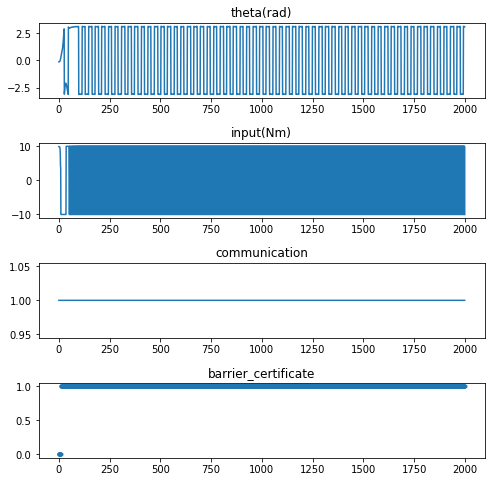

In [8]:
titles = ['theta(rad)', 'input(Nm)', 'communication', 'barrier_certificate'] 
history = a.data_log[0]
x_axis = range(2000)
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(4):
    data = history[:,i]
    plt.subplot(4,1,i+1)
    plt.title(titles[i])
    if i < 3:
        plt.plot(x_axis, data)
    else:
        plt.scatter(x_axis, data, marker='.')
plt.show()

In [9]:
print(np.unique(history[:,1]))

[-2.          0.44251469  2.        ]


(array([ 949.,   11.,    0.,    0.,    4.,   12.,    5.,    3.,    3.,
        1013.]),
 array([-3.14158925e+00, -2.51327466e+00, -1.88496007e+00, -1.25664549e+00,
        -6.28330898e-01, -1.63091561e-05,  6.28298279e-01,  1.25661287e+00,
         1.88492746e+00,  2.51324205e+00,  3.14155663e+00]),
 <a list of 10 Patch objects>)

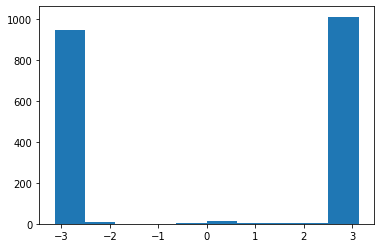

In [11]:
plt.hist(history[:,0])

In [29]:
theta = np.pi / 4
for i in range(1, 5):
    theta = (2*i - 5) * np.pi / 4
    o = np.array([np.cos(theta), np.sin(theta), 1])
    print(_obs_to_rad(o), f'{(2*i - 5)}π/ 4 = {theta}')

-2.356194490192345 -3π/ 4 = -2.356194490192345
-0.7853981633974483 -1π/ 4 = -0.7853981633974483
0.7853981633974483 1π/ 4 = 0.7853981633974483
2.356194490192345 3π/ 4 = 2.356194490192345
